# Pytorch Tutorial

Notebook available here: https://github.com/jakobottar/pytorch-tutorial

Get cat image data here: https://www.dropbox.com/s/y1cxgxec95e181a/cat_images.zip?dl=0

## PyTorch Background

Data in PyTorch is stored in Tensors, which are almost identical to NumPy arrays.

Their key differences are
1. Auto gradient calculation (with `torch.autograd`)
2. Ability to move to a GPU (with `Tensor.to(device)`)

In [1]:
import torch

data = [[1,2,3], [4,5,6], [7,8,9]]
data_tensor = torch.tensor(data)
print(data_tensor)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


In [2]:
ones_tensor = torch.ones(size=data_tensor.shape, dtype=int)
print(ones_tensor)

# these tensors behave almost exactly like numpy arrays
print(ones_tensor @ data_tensor)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])
tensor([[12, 15, 18],
        [12, 15, 18],
        [12, 15, 18]])


## Datasets & DataLoaders

Some datasets are available from Pytorch's own libraries, such as MNIST or Fashion-MNIST

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(training_data)
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


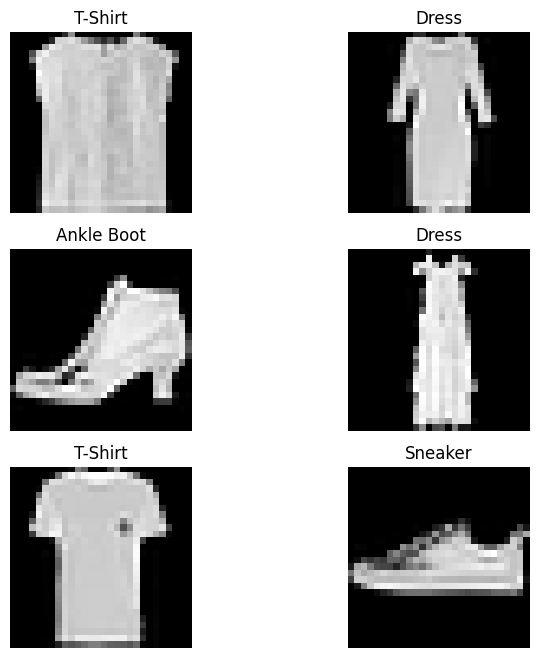

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

You can make custom datasets for your own images easily, just make a child instance of the `torch.utils.data.Dataset` class and implement the following functions:
- `__init__()`: one-time setup of the class, aka the *Constructor*.
- `__len__()`: length of the dataset, used when you call `len(dataset)`.
- `__getitem__()`: what runs when you get an item out of the dataset.

In [5]:
import os
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset


class NoiseDataset(Dataset):
    def __init__(
        self,
        csv_file="TrainingDataSet.csv",
        root_dir_noisy="TrainingDataSet",
        root_dir_ref="./",
        transform=None,
    ):
        # read csv file
        self.name_csv = pd.read_csv(csv_file)

        # store attributes
        self.root_dir_noisy = root_dir_noisy
        self.root_dir_ref = root_dir_ref
        self.transform = transform

    def __len__(self):
        return len(self.name_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # get image filenames
        ref_img_name = os.path.join(self.root_dir_ref, self.name_csv.iloc[idx, 0])
        noisy_img_name = os.path.join(self.root_dir_noisy, self.name_csv.iloc[idx, 2])

        # load images
        ref_image = read_image(ref_img_name)
        noisy_image = read_image(noisy_img_name)

        # apply transforms
        if self.transform:
            ref_image = self.transform(ref_image)
            noisy_image = self.transform(noisy_image)
        return noisy_image, ref_image
        
cats_dataset = NoiseDataset(
            csv_file="data/cats/training.csv",
            root_dir_noisy="data/cats/training",
        )


print(f"len(cats_dataset): {len(cats_dataset)}")

len(cats_dataset): 800


In order to load the datasets into the model, you need wrap them in a `torch.utils.data.DataLoader` class, which handles batches and shuffling.

In [6]:
from torch.utils.data import DataLoader

# FashionMNIST datasets
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# custom cats dataset
cats_dataloader = DataLoader(cats_dataset, batch_size=3, shuffle=True)

# pull a batch off and look at it
noisy_images, ref_images = next(iter(cats_dataloader))
print(f"noisy_images.shape: {noisy_images.shape}")

noisy_images.shape: torch.Size([3, 1, 475, 475])


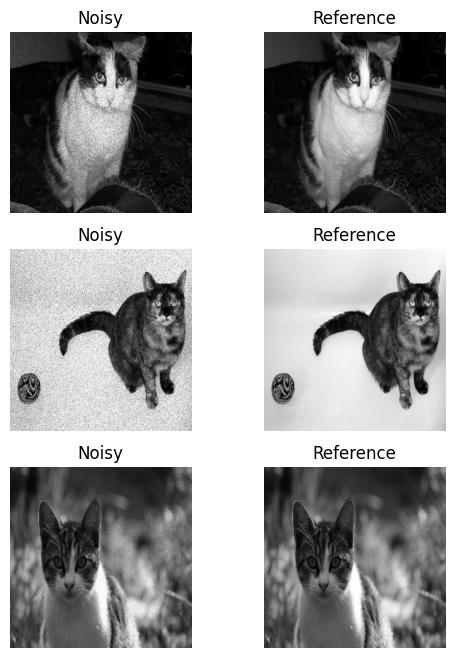

In [7]:
figure = plt.figure(figsize=(6, 8))
rows = noisy_images.shape[0]
for i in range(0, rows):
    figure.add_subplot(rows, 2, (2 * i) + 1)
    plt.title("Noisy")
    plt.axis("off")
    plt.imshow(noisy_images[i].squeeze(), cmap="gray")

    figure.add_subplot(rows, 2, (2 * i) + 2)
    plt.title("Reference")
    plt.axis("off")
    plt.imshow(ref_images[i].squeeze(), cmap="gray")

## Transforms

Sometimes the images you're given are not in the right format for training or you want to do some image augmentation before you put them into a neural net. This is where transforms come in. There's a whole list of transformations you can use ([pytorch.org/vision/stable/transforms.html](https://pytorch.org/vision/stable/transforms.html)), ranging from resizing and cropping to color shifting and blurring. 

`transforms.ToTensor()` can be very useful to convert data from whatever form you loaded as to a Tensor. 

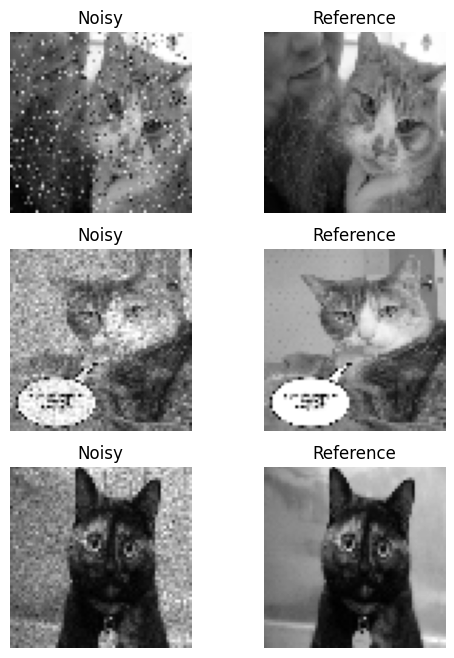

In [8]:
from torchvision import transforms

# compose multiple transforms like this
transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
        ]
    )

# they're applied at the dataset level
cats_dataset = NoiseDataset(
            csv_file="data/cats/training.csv",
            root_dir_noisy="data/cats/training",
            transform=transform
        )

cats_dataloader = DataLoader(cats_dataset, batch_size=3, shuffle=True)

noisy_images, ref_images = next(iter(cats_dataloader))

figure = plt.figure(figsize=(6, 8))
rows = noisy_images.shape[0]
for i in range(0, rows):
    figure.add_subplot(rows, 2, (2 * i) + 1)
    plt.title("Noisy")
    plt.axis("off")
    plt.imshow(noisy_images[i].squeeze(), cmap="gray")

    figure.add_subplot(rows, 2, (2 * i) + 2)
    plt.title("Reference")
    plt.axis("off")
    plt.imshow(ref_images[i].squeeze(), cmap="gray")

## Network Architecture

In [9]:
from torch import nn

# the model can run on either CPU or CUDA (also supports AMD's ROCm)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


You can define a model by making a child instance of the the `nn.Module` class. All network layers are derived from the `nn.Module` class. You need to implement the following functions:
- `__init__()`: same as with the Dataset, one-time setup.
- `forward()`: what happens when you want to pass data through the model, a *forward* pass.

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # input images are 28px by 28px
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10), # there are 10 output classes
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimization and Hyperparameters 
You'll need to set hyperparameters, as well as initialize your loss function and optimizer.

In [11]:
# set hyperparameters
learning_rate = 1e-3
epochs = 5

# initialize loss function
loss_fn = nn.CrossEntropyLoss()

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Training and Testing

Here's where the magic happens. You need to write some code to handle training and testing the model. Best practice is to do this in two functions like shown here.

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # set model to train mode
    model.train()

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # move images to GPU if needed
        X, y = X.to(device), y.to(device)

        # zero gradients from previous step
        optimizer.zero_grad()

        # compute prediction and loss
        pred = model(X) # Remember forward()? This calls that.
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()

        if batch % 200 == 0: # print some status info
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # set model to eval mode
    model.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # move images to GPU if needed
            X, y = X.to(device), y.to(device)

            # compute prediction and loss
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # compare predictions and labels
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299974  [    0/60000]
loss: 2.272446  [12800/60000]
loss: 2.247839  [25600/60000]
loss: 2.196284  [38400/60000]
loss: 2.185750  [51200/60000]
Test Error: 
 Accuracy: 52.1%, Avg loss: 2.153427 

Epoch 2
-------------------------------
loss: 2.151125  [    0/60000]
loss: 2.103305  [12800/60000]
loss: 2.038586  [25600/60000]
loss: 2.012625  [38400/60000]
loss: 1.927700  [51200/60000]
Test Error: 
 Accuracy: 60.7%, Avg loss: 1.887352 

Epoch 3
-------------------------------
loss: 1.846900  [    0/60000]
loss: 1.802204  [12800/60000]
loss: 1.627816  [25600/60000]
loss: 1.568660  [38400/60000]
loss: 1.545758  [51200/60000]
Test Error: 
 Accuracy: 63.5%, Avg loss: 1.520070 

Epoch 4
-------------------------------
loss: 1.467839  [    0/60000]
loss: 1.384109  [12800/60000]
loss: 1.349185  [25600/60000]
loss: 1.328998  [38400/60000]
loss: 1.359106  [51200/60000]
Test Error: 
 Accuracy: 63.8%, Avg loss: 1.254798 

Epoch 5
------------------------

## Saving the model
Once you're done training the model, you should probably save it to use in the future. There are two ways to save it, either the whole object (larger file size), or by weights only (need to load model object before applying weights). Either method works, and you can choose how you want to handle saving and loading.

In [14]:
# save model object
torch.save(model, 'model.pth')
model2 = torch.load('model.pth')

# save model weights
torch.save(model.state_dict(), "model-weights.pth")
model3 = NeuralNetwork() # load new model object
model3.load_state_dict(torch.load("model-weights.pth"))

<All keys matched successfully>

## Convolutional Neural Net Example

It's important to keep track of a tensor's size as it's passing through the model. I like to write out the shape like below. Note that these are dependent on individual images, not by batch. 

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(                                        # in: 1x28x28
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),     # out: 32x26x26
            nn.ReLU(),                                                    # no change
            torch.nn.BatchNorm2d(num_features=32),                        # no change
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),    # out: 64x24x24
            nn.ReLU(),                                                    # no change
            torch.nn.BatchNorm2d(num_features=64),                        # no change
            nn.MaxPool2d(kernel_size=2),                                  # out: 64x12x12
        )
        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=64*12*12, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


cnn = CNN().to(device)
print(cnn)

# set hyperparameters
learning_rate = 1e-3
epochs = 5

# initialize loss function
loss_fn = nn.CrossEntropyLoss()

# initialize optimizer
optimizer = torch.optim.AdamW(cnn.parameters(), lr=learning_rate)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


In [16]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, cnn, loss_fn, optimizer)
    test_loop(test_dataloader, cnn, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303707  [    0/60000]
loss: 1.657503  [12800/60000]
loss: 1.663864  [25600/60000]
loss: 1.601735  [38400/60000]
loss: 1.647428  [51200/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 1.613540 

Epoch 2
-------------------------------
loss: 1.586673  [    0/60000]
loss: 1.562984  [12800/60000]
loss: 1.549176  [25600/60000]
loss: 1.576376  [38400/60000]
loss: 1.600247  [51200/60000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 1.603686 

Epoch 3
-------------------------------
loss: 1.570534  [    0/60000]
loss: 1.586218  [12800/60000]
loss: 1.601288  [25600/60000]
loss: 1.624943  [38400/60000]
loss: 1.674325  [51200/60000]
Test Error: 
 Accuracy: 83.1%, Avg loss: 1.629924 

Epoch 4
-------------------------------
loss: 1.601776  [    0/60000]
loss: 1.553320  [12800/60000]
loss: 1.570563  [25600/60000]
loss: 1.570526  [38400/60000]
loss: 1.639396  [51200/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 1.606335 

Epoch 5
------------------------